# Using CF-Xarray to easily analyze CMORized and non-CMORized output

This notebook demonstrates how to use CF attributes in datasets to write code that generalizes across datasets that follow different naming conventions.

It makes a simple depth plot of zonal velocity at (0°N, 140°W) and uses the [cf_xarray](https://cf-xarray.readthedocs.io/en/latest/) package to take advantage of CF attributes. For example, the zonal velocity variable (named `UVEL` or `uo` depending on output) is extracted using the CF standard name `sea_water_x_velocity`. The associated latitude, longitude variables (`ULAT`, `lat`, `yh`; `ULONG`, `lon`, `xh`) are extracted using cf_xarray logic for identifying appropriate latitude and longitude variables.

There are some outstanding issues:
- CESM-POP2 does not output a nice complete set of CF attributes for each variable. This will need to be added as a post-processing step.
- indexing on a curvilinear lat-lon grid is hard, but xarray will make this more convenient soon.
- indexing along longitudes that could be 0→360 or -180→180 is also hard, but we can fix this when xarray exposes more indexing functionality.

In [4]:
%load_ext watermark

import cf_xarray as cfxr
import dask_jobqueue
import distributed
import intake
import intake_esm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pint_xarray
import xarray as xr
from cf_xarray.units import units  # loads some UDUNITS definitions

import pop_tools

xr.set_options(keep_attrs=True)

%watermark -iv

matplotlib   : 3.3.2
numpy        : 1.19.2
intake       : 0.6.0
cf_xarray    : 0.4.1.dev31+g7a8c620
distributed  : 2.30.0
pint_xarray  : 0.2
pop_tools    : 2020.9.14
xarray       : 0.16.3.dev150+g37522e991
intake_esm   : 2020.8.15
dask_jobqueue: 0.7.1



In [5]:
cluster = dask_jobqueue.PBSCluster(
    cores=1,  # The number of cores you want
    memory='10GB',  # Amount of memory
    processes=1,  # How many processes
    queue='casper',  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR',  # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB',  # Specify resources
    project='ncgd0048',  # Input your project ID here
    walltime='02:00:00',  # Amount of wall time
    interface='ib0',  # Interface to use
)

cluster.scale(6)

In [6]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.1.2:37752 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## TODO: 

- [ ] read data with intake-esm
  `# intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")`
- [ ] Add `pop_tools.add_cf_attributes()`

In [7]:
# CF attributes to add to POP output
cf_attrs = {
    "UVEL": {"standard_name": "sea_water_x_velocity", "cell_measures": "area: UAREA"},
    "VVEL": {"standard_name": "sea_water_y_velocity", "cell_measures": "area: UAREA"},
    "TEMP": {
        "standard_name": "sea_water_potential_temperature",
        "cell_measures": "area: TAREA",
    },
    "SALT": {"standard_name": "sea_water_salinity", "cell_measures": "area: TAREA"},
}


def set_coords(ds):
    """Set nlat, nlon as coordinate variables and identify axis as X, Y"""
    ds["nlat"] = ("nlat", np.arange(ds.sizes["nlat"]), {"axis": "Y"})
    ds["nlon"] = ("nlon", np.arange(ds.sizes["nlon"]), {"axis": "X"})
    return ds

## Read and clean data

First we read in datasets; add nice CF-attributes to CESM-POP; delete a bad `cell_measures` attribute in the CMOR datasets; and delete `units="none"` for two variables in the MOM6 dataset

### CESM-POP

In [8]:
cesm = xr.open_mfdataset(
    "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/ocn/proc/tseries/month_1/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.UVEL.*.nc",
    chunks={"time": 1000, "nlat": 100, "nlon": 10},
    parallel=True,
    data_vars="minimal",
    coords="minimal",
    compat="override",
)
cesm["UVEL"].attrs.update(cf_attrs["UVEL"])  # CESM-POP2 doesn't add standard_name by default
cesm = set_coords(cesm)
cesm

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 24000, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * time                    (time) object 0001-02-01 00:00:00 ... 2001-01-01 ...
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    UVEL                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1000, 60, 100, 10), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### CMORized CESM-POP

In [9]:
cmor = xr.open_mfdataset(
    "/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/uo/gn/latest/*.nc",
    chunks={"time": 1000, "nlat": 100, "nlon": 10},
    coords="minimal",
    compat="override",
    decode_coords="all",  # set bounds variables as coordinates
    parallel=True,
)
cmor = set_coords(cmor)
del cmor["uo"].encoding["cell_measures"]  # = "--OPT"????
cmor

<xarray.Dataset>
Dimensions:    (time: 14400, lev: 60, nlat: 384, nlon: 320, d2: 2, vertices: 4)
Coordinates:
    lat        (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon        (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time       (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(100, 10, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(100, 10, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
Dimensions without coordinates: d2, vertices
Data variables:
    uo         (time, lev, nlat, nlon) float32 dask.array<chunksize=(1000, 60, 100, 10), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T18:33:54Z
    ...                     ...
    variable_id:            uo
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

### CESM-MOM6 z*

In [10]:
mom6zs = xr.open_mfdataset(
    "/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061_zstar_N75.mct.baseline.002/run/*mom6.hm_*.nc",
    parallel=True,
    coords="minimal",
    data_vars="minimal",
    compat="override",
)
# nv and scalar_axis have units="none" which pint cannot handle
del mom6zs.scalar_axis.attrs["units"]
del mom6zs.nv.attrs["units"]
mom6zs

,Array,Chunk
Bytes,51.64 GB,74.20 MB
Shape,"(696, 75, 458, 540)","(1, 75, 458, 540)"
Count,2088 Tasks,696 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,51.64 GB,74.20 MB
Shape,"(696, 75, 458, 540)","(1, 75, 458, 540)"
Count,2088 Tasks,696 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Use pint arrays to represent quantities with units

`cesm.UVEL` is currently an xarray DataArray wrapping a Dask array. Note that it has `units` attribute with value `centimeter/s`

In [12]:
cesm.UVEL

<xarray.DataArray 'UVEL' (time: 24000, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(24000, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Attributes:
    long_name:      Velocity in grid-x direction
    units:          centimeter/s
    grid_loc:       3221
    cell_methods:   time: mean
    standard_name:  sea_water_x_velocity
    cell_measures:  area: UAREA

We can convert the underlying dask arrays to pint "Quantities" using `pint_xarray`. To do so, call `.pint.quantify`

Now we have an xarray DataArray wrapping a Pint Quantity which in turn wraps a dask array (under `Magnitude` in the repr). Note the extra `Units` field in the repr; and that `units` is not in the attributes any more. Pint will keep track of units from here on

In [13]:
cesm = cesm.pint.quantify()
cesm.UVEL

<xarray.DataArray 'UVEL' (time: 24000, z_t: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(24000, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'centimeter / second')>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-b251813...
    ULAT     (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-b251813...
    TLONG    (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-b251813...
    TLAT     (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-b251813...
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Attributes:
    long_name:      Velocity in grid-x direction
    grid_loc:       3221
    cell_methods:   time: mean
    standard_name:  sea_water_x_velocity
    cell_measures:  area: UAREA

Similarly with `cmor`. The cmor-ized dataset has units `m/s`

In [14]:
cmor = cmor.pint.quantify()
cmor.uo

<xarray.DataArray 'uo' (time: 14400, lev: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
    lat      (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-e0a471e...
  * lev      (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon      (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-e0a471e...
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
Attributes: (12/17)
    cell_methods:   time: mean
    comment:        Prognostic x-ward velocity component resolved by the model.
    description:    Prognostic x-ward velocity component resolved by the model.
    frequency:      mon
    id:             uo
    long_name:      Sea Water X Velocity
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water X Velocity
    type:           real
    variable_id:    uo

In [15]:
mom6zs = mom6zs.pint.quantify()
mom6zs.uo

<xarray.DataArray 'uo' (time: 696, zl: 75, yh: 458, xq: 540)>
<Quantity(dask.array<concatenate, shape=(696, 75, 458, 540), dtype=float32, chunksize=(1, 75, 458, 540), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
  * xq       (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.0 71.67 72.33 73.0
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * zl       (zl) float64 1.25 3.75 6.251 ... 5.366e+03 5.619e+03 5.873e+03
  * time     (time) object 0001-01-16 12:00:00 ... 0058-12-16 12:00:00
Attributes:
    long_name:      Sea Water X Velocity
    cell_methods:   zl:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

## Use cf_xarray to extract `sea_water_x_velocity`

In [16]:
# note that `lat` and `lon` are attached
cmor.cf["sea_water_x_velocity"]  # CF standard name

<xarray.DataArray 'uo' (time: 14400, lev: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
  * lev      (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
    lat      (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-e0a471e...
    lon      (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-e0a471e...
Attributes: (12/17)
    cell_methods:   time: mean
    comment:        Prognostic x-ward velocity component resolved by the model.
    description:    Prognostic x-ward velocity component resolved by the model.
    frequency:      mon
    id:             uo
    long_name:      Sea Water X Velocity
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water X Velocity
    type:           real
    variable_id:    uo

In [17]:
# Note that we get `ULAT`, `ULONG`, `UAREA` are attached
cesm.cf["sea_water_x_velocity"]

<xarray.DataArray 'UVEL' (time: 24000, z_t: 60, nlat: 384, nlon: 320)>
<Quantity(dask.array<concatenate, shape=(24000, 60, 384, 320), dtype=float32, chunksize=(1000, 60, 100, 10), chunktype=numpy.ndarray>, 'centimeter / second')>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    UAREA    (nlat, nlon) float64 [cm²] dask.array<open_dataset-b251813acfde5...
    ULONG    (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-b251813...
    ULAT     (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-b251813...
Attributes:
    long_name:      Velocity in grid-x direction
    grid_loc:       3221
    cell_methods:   time: mean
    standard_name:  sea_water_x_velocity
    cell_measures:  area: UAREA

In [18]:
mom6zs.cf["sea_water_x_velocity"]

<xarray.DataArray 'uo' (time: 696, zl: 75, yh: 458, xq: 540)>
<Quantity(dask.array<concatenate, shape=(696, 75, 458, 540), dtype=float32, chunksize=(1, 75, 458, 540), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates:
  * xq       (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.0 71.67 72.33 73.0
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
  * zl       (zl) float64 1.25 3.75 6.251 ... 5.366e+03 5.619e+03 5.873e+03
  * time     (time) object 0001-01-16 12:00:00 ... 0058-12-16 12:00:00
Attributes:
    long_name:      Sea Water X Velocity
    cell_methods:   zl:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

## Compare x velocity across three simulations

We will now make a simple plot. There are `UnitStrippedWarnings` because xarray is pulling out numpy arrays from the pint arrays. This will get fixed.

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.

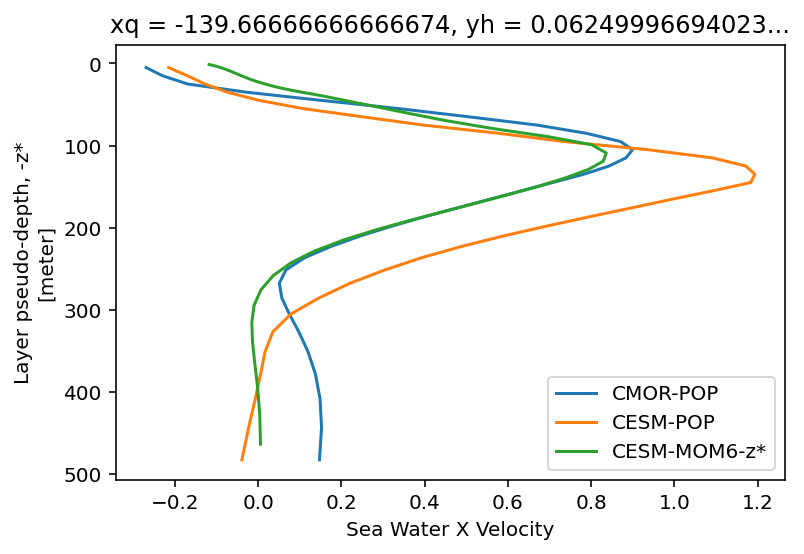

In [20]:
def plot_euc(ds, **plot_kwargs):
    if "nlat" in ds.dims and "nlat" not in ds.coords:
        ds = set_coords(ds)

    # gets UVEL in CESM-POP, "uo" in CESM-MOM6, "uo" in CMOR
    u = ds.cf["sea_water_x_velocity"]

    # find the z-coordinate name: "z_t" in CESM-POP, "lev" in CMOR, "zl" in CESM-MOM6
    Zname = u.cf.coordinates["vertical"][0]

    # Make sure we are using SI units
    # convert velocity to m/s
    # convert the Z-coordinate to m
    u = u.pint.to("m/s").pint.to({Zname: "m"})

    # --- find (0, -140)
    lat = u.cf["latitude"]  # gets possibly 2D latitude variable
    lon = u.cf["longitude"]

    # TODO: Xarray will provide a better solution here in ≈ 6 months
    #     right now, we need to know
    # Unfortunately 220*units.degress_east == -140*degrees_east is False
    # If not, we could avoid this if condition
    if bool(np.all(lon.data > 0)):
        lon_target = 220 * units.degrees_east
    else:
        lon_target = -140 * units.degrees_east
    lat_target = 0 * units.degrees_north

    if lon.ndim == 2:
        # find index corresponding to (0, -140)
        # TODO: we need to extract magnitudes (pure numpy arrays, no units)
        ilat, ilon = np.unravel_index(
            np.argmin(
                (lat - lat_target).data.magnitude ** 2 + (lon - lon_target).data.magnitude ** 2
            ),
            lon.shape,
        )
        # TODO: .isel(X=ilon, Y=ilat) does not work
        # because for the CMOR dataset, "lon" and "nlon" both have axis="X"
        u_sub = u.cf.isel({"X": ilon, "Y": ilat})
    else:
        u_sub = u.cf.sel({"X": lon_target, "Y": lat_target}, method="nearest")

    # now plot the last year for demonstration
    # All datasets here use "time" for the time axis,
    # so using .cf.mean("time") is really just for demo purposes
    (
        u_sub.cf.sel(vertical=slice(500))  # top 500m
        .cf.isel(time=slice(-12, None))
        .cf.mean("time")
        .cf.plot(**plot_kwargs)  # puts 'Z' on the y-axis automatically and
        # makes sure values increase downward (since attrs["positive"] == "down")
    )


plot_euc(cmor, label="CMOR-POP")
plot_euc(cesm, label="CESM-POP")
plot_euc(mom6zs, label="CESM-MOM6-z*")
plt.legend()

## Automatic guessing of coordinates and axes variables.

`cf_xarray` copies over some heuristics from metpy to enable automatically detecting axes and coordinate variables. Calling this function will return a new Dataset or DataArray with new attributes set. You will want to save the return value.

In [21]:
cesm.cf.guess_coord_axis(verbose=True)

I think 'z_t' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'z_t_150m' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'z_w' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'z_w_top' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'z_w_bot' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'lat_aux_grid' is of type 'latitude'. It matched re.compile('y?(nav_lat|lat|gphi)[a-z0-9]*')
I think 'time' is of type 'time'. It has a datetime-like type.
I think 'nlat

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_w: 60, nlat: 384, nlon: 320, time: 24000, d2: 2, z_t_150m: 15, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 [degrees_N] dask.array<open_...
    TLONG                   (nlat, nlon) float64 [degrees_E] dask.array<open_...
    TLAT                    (nlat, nlon) float64 [degrees_N] dask.array<open_...
  * time                    (time) object 0001-02-01 00:00:00 ... 2001-01-01 ...
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 [] dask.array<copy, shape=(3,), ...
    transport_components    (transport_comp) |S384 [] dask.array<copy, shape=...
    transport_regions       (transport_reg) |S384 [] dask.array<copy, shape=(...
    dz                      (z_t) float32 [cm] dask.array<copy, shape=(60,), ...
    dzw                     (z_w) float32 [cm] dask.array<copy, shape=(60,), ...
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(100, 10), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 -0.00347
    sflux_factor            float64 0.1
    nsurface_t              float64 8.61e+04
    nsurface_u              float64 8.297e+04
    time_bound              (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    UVEL                    (time, z_t, nlat, nlon) float32 [cm/s] dask.array...
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [22]:
cmor.cf.guess_coord_axis(verbose=True)

I think 'lat' is of type 'latitude'. It matched re.compile('y?(nav_lat|lat|gphi)[a-z0-9]*')
I think 'lev' is of type 'Z'. It matched re.compile('(z|nav_lev|gdep|lv_|[o]*lev|bottom_top|sigma|h(ei)?ght|altitude|depth|isobaric|pres|isotherm)[a-z_]*[0-9]*')
I think 'lon' is of type 'longitude'. It matched re.compile('x?(nav_lon|lon|glam)[a-z0-9]*')
I think 'nlat' is of type 'Y'. It matched re.compile('y|j|nlat|nj')
I think 'nlon' is of type 'X'. It matched re.compile('x|i|nlon|ni')
I think 'time' is of type 'time'. It has a datetime-like type.
I think 'time_bnds' is of type 'time'. It matched re.compile('\\bt\\b|(time|min|hour|day|week|month|year)[0-9]*')
I think 'time_bnds' is of type 'T'. It matched re.compile('\\bt\\b|(time|min|hour|day|week|month|year)[0-9]*')
I think 'lat_bnds' is of type 'latitude'. It matched re.compile('y?(nav_lat|lat|gphi)[a-z0-9]*')
I think 'lon_bnds' is of type 'longitude'. It matched re.compile('x?(nav_lon|lon|glam)[a-z0-9]*')
I think 'lev_bnds' is of type 'Z'.

<xarray.Dataset>
Dimensions:    (time: 14400, lev: 60, nlat: 384, nlon: 320, d2: 2, vertices: 4)
Coordinates:
    lat        (nlat, nlon) float64 [degrees_N] dask.array<open_dataset-e0a47...
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon        (nlat, nlon) float64 [degrees_E] dask.array<open_dataset-e0a47...
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time       (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 [degrees_N] dask.array<open_dat...
    lon_bnds   (nlat, nlon, vertices) float32 [degrees_E] dask.array<open_dat...
    lev_bnds   (lev, d2) float32 [m] dask.array<copy, shape=(60, 2), dtype=fl...
Dimensions without coordinates: d2, vertices
Data variables:
    uo         (time, lev, nlat, nlon) float32 [m/s] dask.array<concatenate, ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T18:33:54Z
    ...                     ...
    variable_id:            uo
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

## Possibilities?

1. `ds.cmor["thetao"]  # becomes ds.cf["sea_water_potential_temperature"]`
2. Add SGRID info to model output https://sgrid.github.io/sgrid/